### BayFlux Demo Notebook: Sample Toya 2010 WT5h data with E. coli core model
By Tyler W. H. Backman

In this notebook we import data from the following four files, created in an accompanying notebook:
* **File 1:** Metabolic model (.sbml format)
* **File 2:** Extracellular exchange and flux bounds (.csv format)
* **File 3:** Atom transitions for each reaction (.txt format)
* **File 4:** Mass distribution experimental data (.tab format)

#### Load Python libraries

In [1]:
%matplotlib inline

In [2]:
import os
import cobra
from cobra.sampling import MCMCACHRSampler
import bayflux
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
print(cobra.__version__)
print(bayflux.__version__)

cobra/core/dictlist.py:215 SyntaxWarning: "is" with a literal. Did you mean "=="?


0.18.1
1.0


#### Filenames for data import

In [3]:
# Data directory
dataDir = 'input_data'

# File 1: Metabolic model (.sbml format)
modelFile = os.path.join(dataDir, 'TOYA.xml')

# File 2: Extracellular exchange and flux bounds (.csv format)
fluxBoundsFile = os.path.join(dataDir, 'EXCHANGE_FLUXES_TOYA2.csv')

# File 3: Atom transitions for each reaction (.txt format)
transitionsFile = os.path.join(dataDir, 'TOYA_transitions.txt')

# File 4: Mass distribution experimental data (.tab format)
mdvFile = os.path.join(dataDir, 'TOYA_wt5h_Mass_Distibution.txt')

#### Import model and set flux bounds

In [4]:
# Read the model file
cobrapymodel = cobra.io.read_sbml_model(modelFile)
model = bayflux.ReactionNetwork(cobrapymodel)
model

'Ecoli-core' is not a valid SBML 'SId'.


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


Name,Ecoli-core
Memory address,0x07f1d25b35b80
Number of metabolites,47
Number of reactions,63
Number of groups,0
Objective expression,1.0*co2_exchange - 1.0*co2_exchange_reverse_8988e
Compartments,"Cytosol, Extracellular"


Import and apply exchange fluxes from file

In [5]:
model.readFluxConstraints(fluxBoundsFile)

Set some flux bounds to limit the search space of the model. For test purposes we have narrow bounds here
so the notebook runs quickly, for real world models much larger bounds may be necessary and reasonable.

In [6]:
# set maximum flux to limit the search space
limit = 58.5
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

Run FBA (Flux Balance Analysis) to confirm that the model is valid and can carry flux

In [7]:
model.optimize()

,fluxes,reduced_costs
2DDA7Pbm,0.000000,0.0
2DDA7P_exchange,0.000000,0.0
ACACCT,4.300000,0.0
Ac_exchange,4.300000,0.0
ACONT,18.066667,0.0
...,...,...
TA2,0.000000,0.0
TK1,0.000000,0.0
TK2,0.000000,0.0
TK3,0.000000,0.0


#### Read atom transitions and apply to model

In [8]:
model.readAtomTransitions(transitionsFile)

#### Read mass distribution data

In [9]:
importedMDVs = bayflux.readMassDistribution(model, mdvFile)
importedMDVs

  metabolite          atoms       0       1       2       3       4      5  \
0      fdp_c    1,2,3,4,5,6  0.381   0.244   0.081    0.116   0.041  0.017   
1     dhap_c          1,2,3   0.584   0.165   0.094   0.157    None    NaN   
2      3pg_c          1,2,3  0.636   0.173   0.038    0.153    None    NaN   
3      pep_c          1,2,3  0.624   0.165   0.060    0.151    None    NaN   
4      pyr_c          1,2,3  0.636   0.165   0.055    0.145    None    NaN   
5   ru5p_D_c      1,2,3,4,5  0.554   0.143   0.108   0.103   0.021   0.071   
6      r5p_c      1,2,3,4,5  0.537   0.138   0.102   0.124   0.021   0.078   
7      s7p_c  1,2,3,4,5,6,7  0.332   0.197   0.164    0.127   0.073  0.071   
8    mal_L_c        1,2,3,4  0.454   0.252   0.181   0.095    0.018    NaN   

       6     7  
0  0.119   NaN  
1    NaN   NaN  
2    NaN   NaN  
3    NaN   NaN  
4    NaN   NaN  
5    NaN   NaN  
6    NaN   NaN  
7  0.026  0.01  
8    NaN   NaN  

#### Specify the number of extra neutrons in each position of the carbon inputs

In [10]:
substrateLabelingDict = {
    model.metabolites.get_by_id('glc_D_e'): ((0.3, [1,0,0,0,0,0]),(0.2, [1,1,1,1,1,1]),(0.5, [0,0,0,0,0,0]),),
}

#### Pre-compile EMU network

In [11]:
compiledData = bayflux.emuCompile(list(importedMDVs.data.keys()), model, substrateLabelingDict)

#### Placeholder: These functions will be moved into the main package before final release

In [12]:
def normpdf(x, mean, sd):
    # based on this but with np.log added https://codereview.stackexchange.com/a/98891
    # much faster, bur same answer as norm.logpdf
    var = float(sd)**2
    denom = (2*np.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return np.log(num/denom)

def logLikelihood(fluxVector, lcmsResults=importedMDVs, compiledData=compiledData, substrateLabelingDict=substrateLabelingDict, errorSD=0.007041666666666667):

    # simulate labeling distribution
    try:
        results = bayflux.simulateLabeling(compiledData, fluxVector, substrateLabelingDict)
    except np.linalg.LinAlgError:
        print('LinAlgError')
        return np.finfo(np.float32).min # return a really low probability if we get an error
    
    logLikelihood = 0
    
    # find overlap between results and predicted EMUs
    for emu, mdvs in lcmsResults.data.items():
        emuHash = hash(emu)
        found = False
        for singleSize in compiledData:
            if emuHash in singleSize['matrixCoords']['internalEMUs']['hashes']:
                index = singleSize['matrixCoords']['internalEMUs']['hashes'].index(emuHash)
                found = True
                # zip together experimental results and simulated results into pairwise
                # tuples
                for mdv in mdvs:
                    for comparison in zip(mdv, results[singleSize['size']][index]):
                        logLikelihood += normpdf(comparison[0], comparison[1], errorSD)
        assert found == True, 'missing MDV in simulated results for ' + repr(emu)
    return logLikelihood

In [13]:
def pairPlot(samples, reactions, thinning=1):
    # plot sample distribution for warmup samples
    g = sns.PairGrid(samples[reactions].iloc[::thinning, :], diag_sharey=False) # plot only every 10th sample
    # g = sns.PairGrid(samples[reactions], diag_sharey=False)
    g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
    g.map_diag(sns.kdeplot, lw=3, gridsize=100)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)

#### Initialize sampler and collect uniform samples to identify the center of the metabolic model

In [56]:
# initialize the sampler
mcmcachr = cobra.sampling.MCMCACHRSampler(model, thinning=100, seed=4355)

In [57]:
%%time
# should take 2-3 minutes for 1M samples
# collect uniform samples in order to identify the center of the model
centeringSamples = mcmcachr.sample(100000, fluxes=False, validatecheck=True)

acceptance rate: 1.0
CPU times: user 22min 14s, sys: 330 ms, total: 22min 14s
Wall time: 22min 14s


<AxesSubplot:>

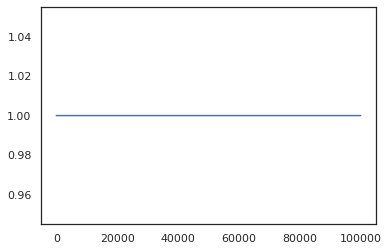

In [60]:
# show sample validation (1.0 = valid)
tol = 1e-6
pd.Series([int(x) for x in (mcmcachr.validate(centeringSamples, feas_tol=tol, bounds_tol=tol) == 'v')]).plot()

In [61]:
# create a list of the reactions we want to plot fluxes for
reactionsToPlot = ['EDD', 'ICL', 'MALS']

<AxesSubplot:>

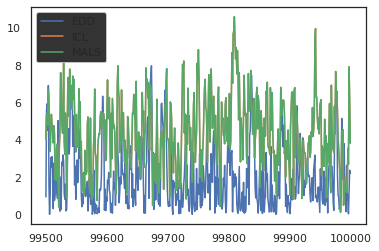

In [62]:
# inspect mixing in the last  warmup samples
centeringSamples[reactionsToPlot][-500:].plot()

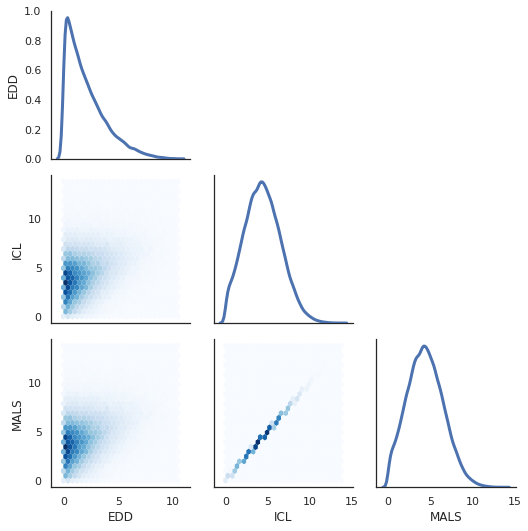

In [63]:
pairPlot(centeringSamples, reactionsToPlot)

#### Infer 13C MFA Posterior distribution from 13C Data using MCMC

In [58]:
%%time
# should take ~12m for 100k samples
posteriorSamples = mcmcachr.sample(100000, likelihood=logLikelihood, validatecheck=True)

acceptance rate: 0.373584
CPU times: user 17d 17h 35s, sys: 23d 21h 25min 27s, total: 41d 14h 26min 3s
Wall time: 15h 36min 3s


In [59]:
posteriorSamples.shape

(100000, 63)

In [64]:
# show frequency of validtions
# from cobrapy code:
#            - 'v' means feasible in bounds and equality constraints
#            - 'l' means a lower bound violation
#            - 'u' means a lower bound validation
#            - 'e' means and equality constraint violation
            
validationResult = pd.Series(mcmcachr.validate(centeringSamples))
validationResult.value_counts()

v    100000
dtype: int64

<AxesSubplot:>

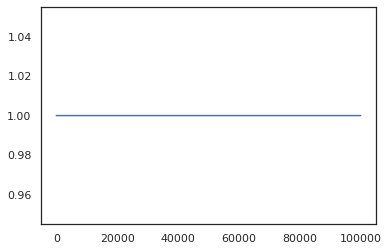

In [65]:
# show sample validation (1.0 = valid)
tol = 1e-6
pd.Series([int(x) for x in (mcmcachr.validate(posteriorSamples, feas_tol=tol, bounds_tol=tol) == 'v')]).plot()

<AxesSubplot:>

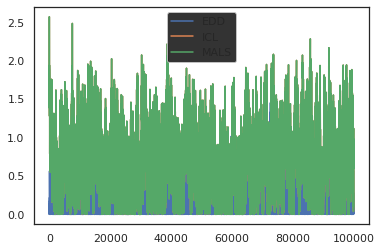

In [66]:
# realSamples[allRxns].plot()
posteriorSamples[reactionsToPlot].plot()

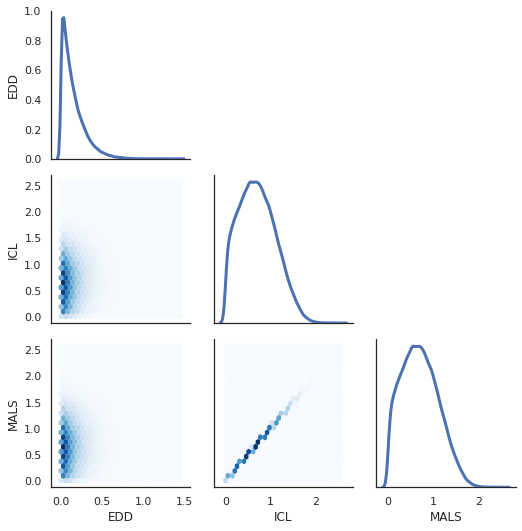

In [67]:
pairPlot(posteriorSamples, reactionsToPlot)

In [68]:
np.save('input_data/ecoli_core_wt5h.npy', posteriorSamples, allow_pickle=False)

### Map reaction names between genome scale and core model

In [74]:
genomescalemodel = cobra.io.rac_cd_sbml_model('ecoli_genome_scale/data/ecoli_genome_scale.xml')

In [83]:
for r in genomescalemodel.metabolites.s7p_c.reactions:
    print(r)

TKT1: r5p_c + xu5p__D_c <=> g3p_c + s7p_c
S7PI: s7p_c --> gmhep7p_c
TALA: g3p_c + s7p_c <=> e4p_c + f6p_c


In [86]:
print(genomescalemodel.reactions.TALA)

TALA: g3p_c + s7p_c <=> e4p_c + f6p_c


In [27]:
genomescalemodelRxnIds = set([r.id for r in genomescalemodel.reactions])

In [28]:
coreModelRxnIds = set([r.id for r in model.reactions])

In [29]:
idIntersection = genomescalemodelRxnIds.intersection(coreModelRxnIds)

In [30]:
for r in model.reactions:
    print(r)

2DDA7Pbm: 2dda7p_c --> 2dda7pbm_c
2DDA7P_exchange: 2dda7pbm_c --> 
ACACCT: accoa_c --> ac_e
Ac_exchange: ac_e --> 
ACONT: cit_c --> icit_c
AKGDH: akg_c --> co2_c + succoa_c
AcCoabm: accoa_c --> accoabm_c
AcCoa_exchange: accoabm_c --> 
co2_exchange: co2_c --> 
glc_exchange: glc_D_e <-- 
CS: accoa_c + oaa_c --> cit_c
DDPA: e4p_c + pep_c --> 2dda7p_c
DHAPT: dha_c + pep_c --> dhap_c + pyr_c
EDA: 2ddg6p_c --> g3p_c + pyr_c
EDD: 6pgc_c --> 2ddg6p_c
ENO: 2pg_c <=> pep_c
F6PA: f6p_c --> dha_c + g3p_c
F6Pbm: f6p_c --> f6pbm_c
F6P_exchange: f6pbm_c --> 
FBA: fdp_c <=> dhap_c + g3p_c
FUM: fum_c --> mal_L_c
G6PDH2r: g6p_c --> 6pgl_c
G6Pbm: g6p_c --> g6pbm_c
G6P_exchange: g6pbm_c --> 
GAPD: g3p_c --> 13dpg_c
GLCpts: glc_D_e + pep_c --> g6p_c + pyr_c
GLUDy: glu_L_c <=> akg_c
GLUbm: glu_L_c --> glubm_c
GLU_exchange: glubm_c --> 
GND: 6pgc_c --> co2_c + ru5p_D_c
ICDHyr: icit_c --> akg_c + co2_c
ICL: icit_c --> glx_c + succ_c
MALS: accoa_c + glx_c --> mal_L_c
MDH: mal_L_c <=> oaa_c
ME1: mal_L_c --> co2

In [31]:
# idMap = {r.id: '' for r in model.reactions}
# for id in idIntersection:
#     idMap[id] = id

In [140]:
idmap = {
 # '2DDA7Pbm': '',
 # '2DDA7P_exchange': '',
 # 'ACACCT': '',
 'Ac_exchange': 'EX_ac_e',
 'ACONT': 'ACONTb',
 'AKGDH': 'AKGDH',
 # 'AcCoabm': '',
 # 'AcCoa_exchange': '',
 'co2_exchange': 'EX_co2_e',
 'glc_exchange': 'EX_glc__D_e',
 'CS': 'CS',
 'DDPA': 'DDPA',
 'DHAPT': 'DHAPT',
 'EDA': 'EDA',
 'EDD': 'EDD',
 'ENO': 'ENO',
 'F6PA': 'F6PA',
 # 'F6Pbm': '',
 # 'F6P_exchange': '',
 'FBA': 'FBA',
 'FUM': 'FUM',
 'G6PDH2r': 'G6PDH2r',
 # 'G6Pbm': '',
 # 'G6P_exchange': '',
 'GAPD': 'GAPD',
 # 'GLCpts': 'GLCptspp',
 'GLUDy': 'GLUDy',
 # 'GLUbm': '',
 # 'GLU_exchange': '',
 'GND': 'GND',
 'ICDHyr': 'ICDHyr',
 'ICL': 'ICL',
 'MALS': 'MALS',
 'MDH': 'MDH',
 'ME1': 'ME1',
 # 'OAAbm': '',
 # 'OAA_exchange': '',
 'PDH': 'PDH',
 # 'PEPbm': '',
 # 'PEP_exchange': '',
 'PFK': 'PFK',
 # '3PG_exchange': '',
 'PGI': 'PGI',
 'PGK': 'PGK',
 'PGL': 'PGL',
 'PGM': 'PGM',
 'PPC': 'PPC',
 'PPCK': 'PPCK',
 'PYK': 'PYK',
 # 'PYRbm': '',
 # 'PYR_exchange': '',
 # 'R5Pbm': '',
 # 'R5P_exchange': '',
 'RPE': 'RPE',
 'RPI': 'RPI',
 'SUCD1i': 'SUCDi',
 'SUCOAS': 'SUCOAS',
 # 'TA1': '',
 # 'TA2': '',
 # 'TK1': '',
 # 'TK2': '',
 # 'TK3': '',
 'TPI': 'TPI'
}

### import genome scale fluxes

In [34]:
# code from bayflux.subsample, because this server has an old version of bayflux without this

def subSample(inputFile, chains, warmupLength, sampleSize, model, netfluxOnly=True):
    # Reads in a set of BayFlux samples from a .npy inputFile, with a given number of chains
    # and warmup samples. Will keep a representative set of integer sampleSize samples occuring after
    # the first 'warmupLength' samples on each chain, and discard the rest. If netfluxOnly=True,
    # only net flux values are returned.
    
    # read in data
    data = np.load(inputFile, mmap_mode='r')
    
    # confirm we have enough valid samples
    assert data.shape[0] >= (sampleSize + (chains * warmupLength)), 'not enough samples'
    
    # Create a list of integers selecting 100k points to remove from the above samples
    # Discard the first 1/4 from each chain
    samplesPerChain = int(data.shape[0] / chains)

    # step size to keep
    # here we use a floating point step size, which gets converted to an integer
    # before indexing, allowing for unevenly spaced increments- thereby letting the
    # subset scale to the desired size
    stepSize = (samplesPerChain - warmupLength) / (sampleSize / chains)
    
    # store inidces samples to be kept in a list
    samplesToKeep = []

    # interate over chains and get indices of samples to keep
    for chain in range(0, chains):
              
        # create series of sample numbers to keep for this chain
        subsetToKeepThisChain = [int(x) for x in np.arange(warmupLength, samplesPerChain, stepSize)]
        
        # assert that each index is unique
        assert len(set(subsetToKeepThisChain)) == len(subsetToKeepThisChain), 'sample indices not unique- not enough samples?'
        
        # adjust sample position based on which chain we're on
        subsetToKeep = [i + (samplesPerChain * chain) for i in subsetToKeepThisChain]
        
        # append indices to list of samples to be kept
        samplesToKeep = samplesToKeep + subsetToKeep
    
    # extract the subset of samples to keep
    dataSubset = data[samplesToKeep]
    
    # put the samples in a Pandas DF
    dataSubset = pd.DataFrame(dataSubset, columns=[v.name for v in model.variables])
    
    if netfluxOnly:
        # substract both directions to get netFlux
        dataSubset = np.subtract(dataSubset.iloc[0::1,0::2], dataSubset.iloc[0::1,1::2])
        
    # cofirm we did the math right and we got the right number of samples to return    
    assert dataSubset.shape[0] == sampleSize, 'error- trying to return the wrong number of samples!'
    
    return dataSubset

In [35]:
genomeScaleSamples = subSample('ecoli_genome_scale/outputdata/bayflux_ecoli_genomescale001.npy', 4, 10000, 100000, genomescalemodel, netfluxOnly=True)

/tmp/ipykernel_91566/354868144.py:51 FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [88]:
genomeScaleSamples

,12PPDRtex,12PPDRtpp,3HAD100,3HAD120,3HAD121,3HAD140,3HAD141,3HAD160,3HAD161,3HAD40,...,VALt2rpp,VALtex,VPAMTr,XANt2pp,XANtpp,ZN2abcpp,ZN2t3pp,ZN2tpp,ZNabcpp,Zn2tex
0,-0.005405,-0.005405,0.308695,0.183736,0.124959,0.106178,0.124959,0.106018,0.124959,0.308695,...,-0.017938,-0.000358,5.034446,0.334606,-0.334606,0.063857,0.556809,0.600548,0.022741,0.002623
1,-0.014278,-0.014278,0.301414,0.176495,0.124919,0.106586,0.124919,0.105985,0.124919,0.301414,...,-0.038474,-0.033817,5.209966,0.191436,-0.191436,0.057512,0.420545,0.408853,0.071827,0.002623
2,-0.005992,-0.005992,0.309010,0.184137,0.124873,0.108009,0.124873,0.105945,0.124873,0.309010,...,-0.073124,-0.022373,5.271815,0.143427,-0.143427,0.055691,0.391183,0.392385,0.057110,0.002622
3,-0.012442,-0.012442,0.301550,0.176687,0.124863,0.106949,0.124863,0.105937,0.124863,0.301550,...,-0.030247,-0.001400,5.183720,0.037255,-0.037255,0.098084,0.042726,0.068555,0.074877,0.002621
4,-0.010064,-0.010064,0.299777,0.174779,0.124998,0.106203,0.124998,0.106052,0.124998,0.299777,...,-0.025450,-0.010254,4.707457,0.061572,-0.061572,0.010654,0.146808,0.079362,0.080725,0.002624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.015630,-0.015630,0.298097,0.173118,0.124980,0.106245,0.124980,0.106036,0.124980,0.298097,...,-0.344669,-0.118398,24.392032,0.157112,-0.157112,0.071392,0.270479,0.304814,0.039681,0.002624
99996,-0.014136,-0.014136,0.299255,0.174114,0.125141,0.106342,0.125141,0.106173,0.125141,0.299255,...,-0.362870,-0.134415,24.422741,0.123088,-0.123088,0.062070,0.176759,0.176604,0.064852,0.002627
99997,-0.012277,-0.012277,0.304829,0.179927,0.124902,0.106178,0.124902,0.105970,0.124902,0.304829,...,-0.441789,-0.121094,24.430692,0.300266,-0.300266,0.039397,0.132167,0.142116,0.032070,0.002622
99998,-0.017575,-0.017575,0.302938,0.178084,0.124854,0.106285,0.124854,0.105929,0.124854,0.302938,...,-0.464181,-0.113956,23.808255,0.000485,-0.000485,0.025423,0.043047,0.035379,0.035713,0.002621


In [113]:
# store list of reactions which converged in samples (from analyze notebook)
converged = ['12PPDRtex',
 '12PPDRtpp',
 '3HAD100',
 '3HAD120',
 '3HAD40',
 '3HAD60',
 '3HAD80',
 '3OAR100',
 '3OAR120',
 '3OAR140',
 '3OAR40',
 '3OAR60',
 '3OAR80',
 '3OAS100',
 '3OAS120',
 '3OAS140',
 '3OAS60',
 '3OAS80',
 'A5PISO',
 'AACTOOR',
 'ABTA',
 'ABUTD',
 'ABUTt2pp',
 'ABUTtex',
 'ACALD',
 'ACCOAC',
 'ACGK',
 'ACGS',
 'ACHBS',
 'ACKr',
 'ACLS',
 'ACOATA',
 'ACODA',
 'ACOTA',
 'ACSERtex',
 'ACSERtpp',
 'ACt2rpp',
 'ACt4pp',
 'ADK1',
 'ADNK1',
 'ADSK',
 'ADSL1r',
 'ADSS',
 'AGMHE',
 'AGMT',
 'AGPR',
 'AHCYSNS',
 'AKGDH',
 'ALAR',
 'ALCD2x',
 'ALDD2x',
 'ALR2',
 'ALR4x',
 'AOBUTDs',
 'ARBTNR1',
 'ARBTNabcpp',
 'ARBTNexs',
 'ARBTNtex',
 'ARBTNtonex',
 'ARBTNtpp',
 'ARGDC',
 'ARGORNt7pp',
 'ARGSL',
 'ARGSS',
 'ARGabcpp',
 'ARGt3pp',
 'ASAD',
 'ASNN',
 'ASNS1',
 'ASNS2',
 'ASNabcpp',
 'ASNt2rpp',
 'ASPK',
 'ASPT',
 'ASPTA',
 'AST',
 'ATPS4rpp',
 'BPNT',
 'CBMKr',
 'CBPS',
 'CD2t3pp',
 'CD2tpp',
 'CITL',
 'CO2tex',
 'CO2tpp',
 'COBALT2t3pp',
 'COBALT2tpp',
 'CRNDabcpp',
 'CRNDt2rpp',
 'CRNabcpp',
 'CRNt2rpp',
 'CTBTabcpp',
 'CTBTt2rpp',
 'CYSDS',
 'CYSS',
 'CYSabc2pp',
 'CYSabcpp',
 'CYStex',
 'CYStpp',
 'CYTBD2pp',
 'CYTBDpp',
 'CYTBO3_4pp',
 'CYTK1',
 'DADA',
 'DALAt2pp',
 'DALAtex',
 'DHAD1',
 'DHAD2',
 'DHAPT',
 'DHPTDCs',
 'DM_hmfurn_c',
 'DTMPK',
 'D_LACt2pp',
 'D_LACtex',
 'EAR100x',
 'EAR100y',
 'EAR120x',
 'EAR120y',
 'EAR40x',
 'EAR40y',
 'EAR80x',
 'EAR80y',
 'EDA',
 'EDD',
 'ETOHt2rpp',
 'ETOHtex',
 'EX_12ppd__R_e',
 'EX_4abut_e',
 'EX_acser_e',
 'EX_ala__D_e',
 'EX_co2_e',
 'EX_cys__L_e',
 'EX_etoh_e',
 'EX_fe2_e',
 'EX_fe3_e',
 'EX_fum_e',
 'EX_glcn_e',
 'EX_glu__L_e',
 'EX_h2o_e',
 'EX_h2s_e',
 'EX_h_e',
 'EX_ile__L_e',
 'EX_kdo2lipid4_e',
 'EX_lac__D_e',
 'EX_leu__L_e',
 'EX_nh4_e',
 'EX_o2_e',
 'EX_pi_e',
 'EX_ptrc_e',
 'EX_pyr_e',
 'EX_ser__L_e',
 'EX_so4_e',
 'EX_succ_e',
 'EX_urea_e',
 'EX_val__L_e',
 'F6PA',
 'FADRx',
 'FADRx2',
 'FBA',
 'FBP',
 'FE2t2pp',
 'FE2t3pp',
 'FE2tex',
 'FE2tpp',
 'FE3tex',
 'FEROpp',
 'FLDR',
 'FORt2pp',
 'FORtppi',
 'FTHFD',
 'FUM',
 'FUMt2_2pp',
 'FUMt2_3pp',
 'FUMtex',
 'G1PACT',
 'G3PD2',
 'G3PT',
 'G5SD',
 'G6PDH2r',
 'G6PP',
 'GALUi',
 'GAPD',
 'GARFT',
 'GART',
 'GF6PTA',
 'GGGABADr',
 'GGGABAH',
 'GGPTRCO',
 'GGPTRCS',
 'GHMT2r',
 'GK1',
 'GLCDpp',
 'GLCNtex',
 'GLCabcpp',
 'GLCptspp',
 'GLCt2pp',
 'GLNS',
 'GLU5K',
 'GLUABUTt7pp',
 'GLUDC',
 'GLUDy',
 'GLUN',
 'GLUSy',
 'GLUabcpp',
 'GLUt2rpp',
 'GLUt4pp',
 'GLUtex',
 'GLYAT',
 'GLYCDx',
 'GLYCK2',
 'GLYCL',
 'GLYOX',
 'GLYOX3',
 'GMHEPAT',
 'GMHEPK',
 'GMHEPPA',
 'GMPR',
 'GMPS2',
 'GND',
 'GTHRDabc2pp',
 'GTHRDabcpp',
 'GUAt2pp',
 'GUAtpp',
 'H2Otex',
 'H2Otpp',
 'H2SO',
 'H2St1pp',
 'H2Stex',
 'HCO3E',
 'HCYSMT',
 'HEX1',
 'HISabcpp',
 'HISt2rpp',
 'HSDy',
 'HSK',
 'HXPRT',
 'Htex',
 'ILETA',
 'ILEabcpp',
 'ILEt2rpp',
 'ILEtex',
 'IMPD',
 'IPMD',
 'IPPMIa',
 'IPPMIb',
 'IPPS',
 'K2L4Aabcpp',
 'K2L4Atex',
 'KARA1',
 'KARA2',
 'KAS14',
 'KAS15',
 'KDOCT2',
 'KDOPP',
 'KDOPS',
 'Kt2pp',
 'Kt3pp',
 'LALDO2x',
 'LCARR',
 'LDH_D',
 'LDH_D2',
 'LEUTAi',
 'LEUabcpp',
 'LEUt2rpp',
 'LEUtex',
 'LGTHL',
 'LPADSS',
 'LYSabcpp',
 'LYSt2pp',
 'LYSt3pp',
 'MALS',
 'MCITD',
 'MCITL2',
 'MCITS',
 'MCOATA',
 'MDH',
 'MDH2',
 'MDH3',
 'ME1',
 'ME2',
 'METAT',
 'MG2t3_2pp',
 'MG2tpp',
 'MG2uabcpp',
 'MGSA',
 'MICITDr',
 'MMCD',
 'MME',
 'MMM2',
 'MN2t3pp',
 'MN2tpp',
 'MNt2pp',
 'MOAT',
 'MOAT2',
 'MTHFC',
 'MTHFD',
 'NACODA',
 'NADH10',
 'NADH16pp',
 'NADH17pp',
 'NADH5',
 'NADK',
 'NADPHQR2',
 'NADPHQR3',
 'NADPPPS',
 'NADTRHD',
 'NAt3_1p5pp',
 'NAt3_2pp',
 'NAt3pp',
 'NDPK1',
 'NDPK2',
 'NDPK3',
 'NDPK4',
 'NDPK8',
 'NH4tex',
 'NH4tpp',
 'NI2abcpp',
 'NI2t3pp',
 'NI2tpp',
 'NI2uabcpp',
 'NTP3',
 'NTP5',
 'NTPP2',
 'NTPP4',
 'NTPP7',
 'NTPP8',
 'O2tex',
 'O2tpp',
 'OAADC',
 'OBTFL',
 'OCBT',
 'OMCDC',
 'ORNDC',
 'ORNabcpp',
 'P5CR',
 'PAPSR',
 'PDH',
 'PFK',
 'PGAMT',
 'PGCD',
 'PGI',
 'PGK',
 'PGL',
 'PGMT',
 'PIt2rpp',
 'PItex',
 'PIuabcpp',
 'POX',
 'PPA',
 'PPA2',
 'PPC',
 'PPCK',
 'PPK2',
 'PPK',
 'PPM',
 'PPS',
 'PROD2',
 'PROabcpp',
 'PRPPS',
 'PSERT',
 'PSP_L',
 'PTAr',
 'PTRCORNt7pp',
 'PTRCTA',
 'PTRCabcpp',
 'PTRCt2pp',
 'PTRCtex',
 'PUNP1',
 'PUNP2',
 'PUNP6',
 'PYK',
 'PYRt2rpp',
 'PYRtex',
 'RHCCE',
 'RNDR1',
 'RNTR1c',
 'RPE',
 'RPI',
 'S7PI',
 'SADH',
 'SADT2',
 'SERAT',
 'SERD_L',
 'SERtex',
 'SGDS',
 'SGSAD',
 'SO4tex',
 'SOTA',
 'SSALx',
 'SSALy',
 'SUCCt2_3pp',
 'SUCCt3pp',
 'SUCCtex',
 'SUCFUMtpp',
 'SUCOAS',
 'SULR',
 'SULabcpp',
 'TALA',
 'TDP',
 'TDSK',
 'THD2pp',
 'THIORDXi',
 'THRA',
 'THRD',
 'THRD_L',
 'THRS',
 'THRabcpp',
 'THRt2pp',
 'TKT1',
 'TKT2',
 'TMPK',
 'TPI',
 'TRDR',
 'U23GAAT',
 'UAGAAT',
 'UAGDP',
 'UHGADA',
 'UMPK',
 'UREAtex',
 'UREAtpp',
 'USHD',
 'VALabcpp',
 'VALt2rpp',
 'VALtex',
 'XANt2pp',
 'XANtpp',
 'ZN2abcpp',
 'ZN2t3pp',
 'ZN2tpp',
 'ZNabcpp']

In [141]:
# filter idmap to include only reactions which converged in the genome scale sampling
filteredidmap = {}

for key, value in idmap.items():
    if value in converged:
        filteredidmap[key] = value

In [148]:
len(filteredidmap)

27

In [149]:
27/2

13.5

### Plot fluxes for core model

In [207]:
# reactionstoshow = 10
netSamples = posteriorSamples[list(filteredidmap.keys())]
#reactionsByCertainty = list(pd.DataFrame.std(netSamples, axis=0).sort_values().index)
reactionsByCertainty = list(pd.DataFrame.median(netSamples, axis=0).sort_values().index)
# reactionstoshow = len(reactionsByCertainty) - reactionstoshow
mostCertain = netSamples.loc[:,reactionsByCertainty[0:14]]
reactionsByCertainty.reverse()
leastCertain = netSamples.loc[:,reactionsByCertainty[0:13]]

In [220]:
netSamples.to_csv('input_data/coressamples.csv')

In [176]:
df1 = pd.melt(leastCertain, var_name='g', value_name='x')

In [179]:
df1.insert(2, "source", "core")

In [181]:
df2.insert(2, "source", "genome")

In [184]:
mergedDF = pd.concat([df1, df2])

In [188]:
mergedDF

,g,x,source
0,PPC,3.157101,core
1,PPC,3.111994,core
2,PPC,3.147324,core
3,PPC,3.337379,core
4,PPC,3.361682,core
...,...,...,...
1299995,PGL,3.698307,genome
1299996,PGL,3.339644,genome
1299997,PGL,3.284095,genome
1299998,PGL,3.189260,genome


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


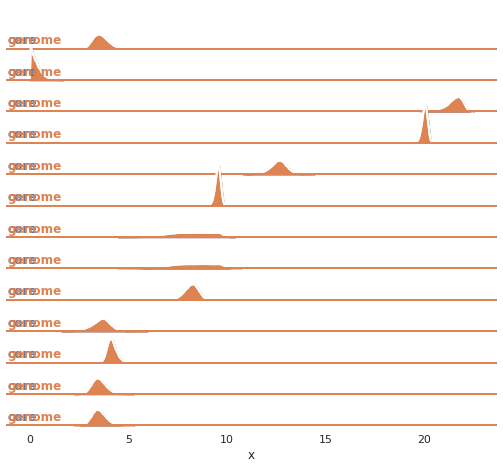

In [201]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
# g = sns.FacetGrid(mergedDF, row="g", hue="source", aspect=15, height=.5, palette=pal)
g = sns.FacetGrid(mergedDF, row="g", hue="source", aspect=15, height=.5)


# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
     fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(xlim=(0,30))
g.despine(bottom=True, left=True)

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


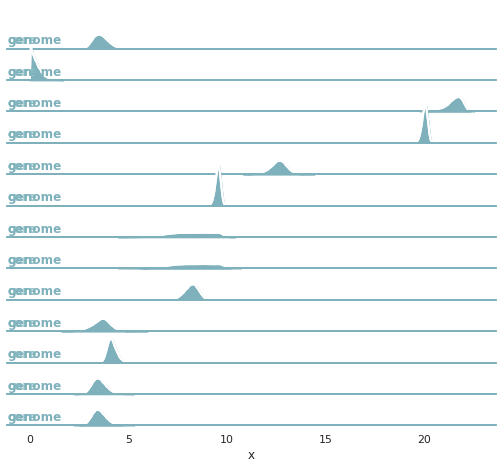

In [192]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
g = sns.FacetGrid(mergedDF, row="g", hue="source", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(xlim=(0,30))
g.despine(bottom=True, left=True)

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


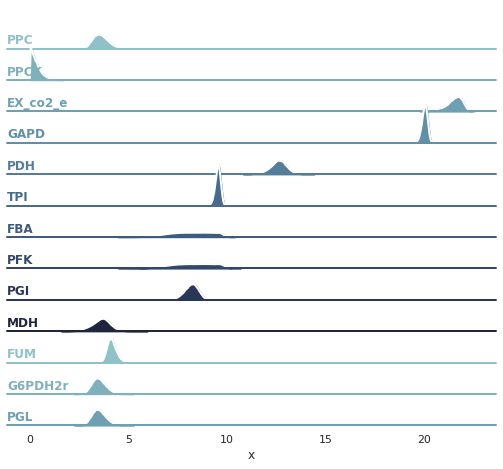

In [173]:
df = pd.melt(leastCertain, var_name='g', value_name='x')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(xlim=(0,30))
g.despine(bottom=True, left=True)

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


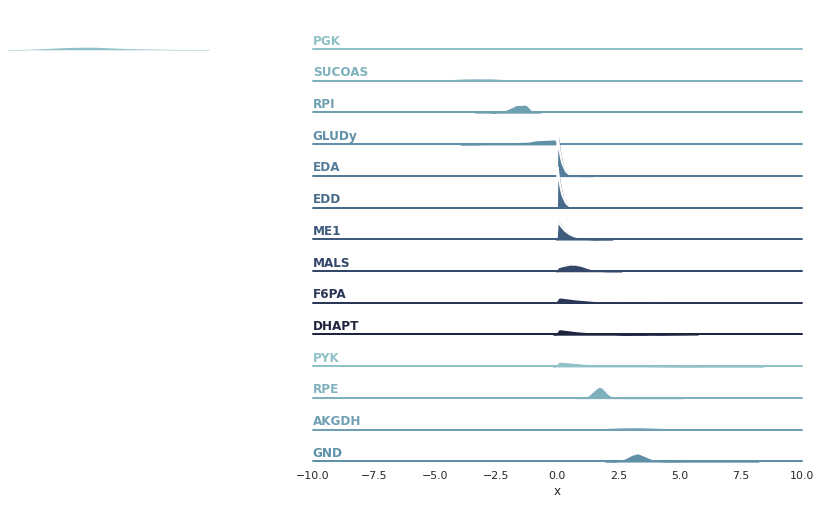

In [168]:
df = pd.melt(mostCertain, var_name='g', value_name='x')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(-10,10))
g.despine(bottom=True, left=True)

### plot genome scale fluxes

In [169]:
genomeScaleReactionsByCertainty = [filteredidmap[r] for r in reactionsByCertainty]
genomeScaleReactionsByCertainty

['PPC',
 'PPCK',
 'EX_co2_e',
 'GAPD',
 'PDH',
 'TPI',
 'FBA',
 'PFK',
 'PGI',
 'MDH',
 'FUM',
 'G6PDH2r',
 'PGL',
 'GND',
 'AKGDH',
 'RPE',
 'PYK',
 'DHAPT',
 'F6PA',
 'MALS',
 'ME1',
 'EDD',
 'EDA',
 'GLUDy',
 'RPI',
 'SUCOAS',
 'PGK']

In [217]:
plotSamples = genomeScaleSamples.loc[:,genomeScaleReactionsByCertainty]

In [222]:
# plotSamples.to_pickle('input_data/genomescalesamples.pickle')
plotSamples.to_csv('input_data/genomescalesamples.csv')

In [170]:
mostCertain = genomeScaleSamples.loc[:,genomeScaleReactionsByCertainty[0:14]]
reactionsByCertainty.reverse()
leastCertain = genomeScaleSamples.loc[:,genomeScaleReactionsByCertainty[0:13]]

In [211]:
genomeScaleSamples.columns

Index(['12PPDRtex', '12PPDRtpp', '3HAD100', '3HAD120', '3HAD121', '3HAD140',
       '3HAD141', '3HAD160', '3HAD161', '3HAD40',
       ...
       'VALt2rpp', 'VALtex', 'VPAMTr', 'XANt2pp', 'XANtpp', 'ZN2abcpp',
       'ZN2t3pp', 'ZN2tpp', 'ZNabcpp', 'Zn2tex'],
      dtype='object', length=719)

In [178]:
df2 = pd.melt(leastCertain, var_name='g', value_name='x')
df2

,g,x
0,PPC,3.157101
1,PPC,3.111994
2,PPC,3.147324
3,PPC,3.337379
4,PPC,3.361682
...,...,...
1299995,PGL,3.698307
1299996,PGL,3.339644
1299997,PGL,3.284095
1299998,PGL,3.189260


/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


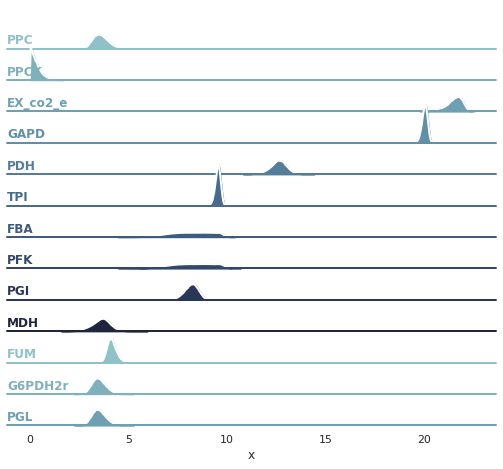

In [171]:
df = pd.melt(leastCertain, var_name='g', value_name='x')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(xlim=(0,30))
g.despine(bottom=True, left=True)

/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/usr/local/share/jupyteruser/.virtualenvs/bayflux_3.8-kVhk6Sab/lib/python3.8/site-packages/seaborn/axisgrid.py:88 UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


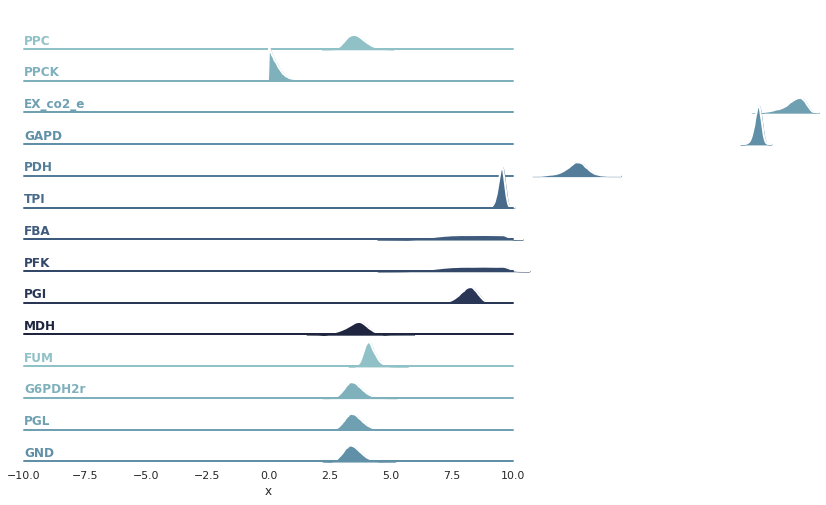

In [172]:
df = pd.melt(mostCertain, var_name='g', value_name='x')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(reactionstoshow, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xlim=(-10,10))
g.despine(bottom=True, left=True)